# Stable Diffusion acceleration with TensorRT

In [ ]:
# Copyright 2023 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Install Prerequisites

In [1]:
# Disable warnings if pip is run as root.
import os
os.environ['PIP_ROOT_USER_ACTION']='ignore'

In [2]:
!python -m pip install --upgrade --quiet pip

### Check NVIDIA GPU availability

TensorRT acceleration for Diffusion models is available for NVIDIA Turing, Ampere, Ada Lovelace, and Hopper GPUs.

For the following illustration we are using an A100 40GB GPU.

In [3]:
!nvidia-smi

Wed May  3 04:32:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.44       Driver Version: 515.44       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Graphics...  Off  | 00000000:01:00.0 Off |                    0 |
| 65%   64C    P0    81W / 200W |     86MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install PyTorch 1.x

NOTE: this is a temporary workaround for ONNX export issues observed in PyTorch 2.0,

In [4]:
!pip install --upgrade --quiet "torch <2.0.0"

In [5]:
import torch
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.14.0a0+44dac51


### Install NVIDIA TensorRT

TensorRT 8.6+ includes Stable Diffusion model optimizations out of the box.

In [6]:
!pip install --upgrade --quiet "tensorrt>=8.6"

In [7]:
import tensorrt
print(f"TensorRT version: {tensorrt.__version__}")

TensorRT version: 8.6.1


### Install TensorRT Utilities

The TensorRT pipeline implementation in diffusers uses `polygraphy` API to reduce boilerplate code and simplify deployment of ONNX models in TensorRT.

The pipeline also uses `onnx-graphsurgeon` and `onnxruntime` to sanitize (constant folding & shape inference) the exported ONNX models for deployment.

In [8]:
!pip install --extra-index-url https://pypi.ngc.nvidia.com --upgrade --quiet "onnx-graphsurgeon" "onnxruntime" "polygraphy"

### Install HuggingFace libraries

HuggingFace `diffusers` library provides an implementation of the Stable Diffusion pipeline, including the constituent models. TensorRT txt2img pipeline was added in `diffusers` v0.16.0, which is a minimum requirement for the following illustration.

The OpenAI CLIP text encoder and tokenizer models are obtained from HuggingFace `transformers` package.

In [9]:
!pip install --upgrade --quiet "accelerate" "diffusers>=0.16" "transformers"

In [10]:
import diffusers
print(f"diffusers version: {diffusers.__version__}")

diffusers version: 0.16.1


# Run Stable Diffusion

The Stable Diffusion text2image pipeline takes a text prompt as an input and generates an image. A latent seed is used generate an initial random latent of size 64×64 and the text prompt is transformed to text embeddings of size 77×768 by a CLIP text encoder.

Next the U-Net iteratively denoises the random latent representation over a user-specified number of steps while being conditioned on the text embeddings. The output of the U-Net in each iteration is a noise residual which is transformed into denoised latent image representation via a scheduler algorithm.

For more information, see this [blog post](https://huggingface.co/blog/stable_diffusion)

### Import SD pipeline from diffusers

`StableDiffusionPipeline` contains all models required for inference - a tokenizer, `CLIPTextModel` (text encoder), `UNet2DConditionModel` (denoising UNet), and `AutoencoderKL` (VAE decoder).

In [11]:
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline

### Initialize DDIM scheduler

A custom noise scheduler can be specified by the user. In our example we use [DDIM](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddim).

In [12]:
from diffusers import DDIMScheduler
scheduler = DDIMScheduler.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="scheduler")

### Initialize native txt2img pipeline

In [13]:
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    revision='fp16',
    torch_dtype=torch.float16,
    scheduler=scheduler,
    image_height=512,
    image_width=512)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

### Load the pipeline models to GPU

In [14]:
pipe = pipe.to("cuda")

### Run native txt2img pipeline

The native pipeline in diffusers is implemented in PyTorch. Run it and display the generated image.

  0%|          | 0/50 [00:00<?, ?it/s]

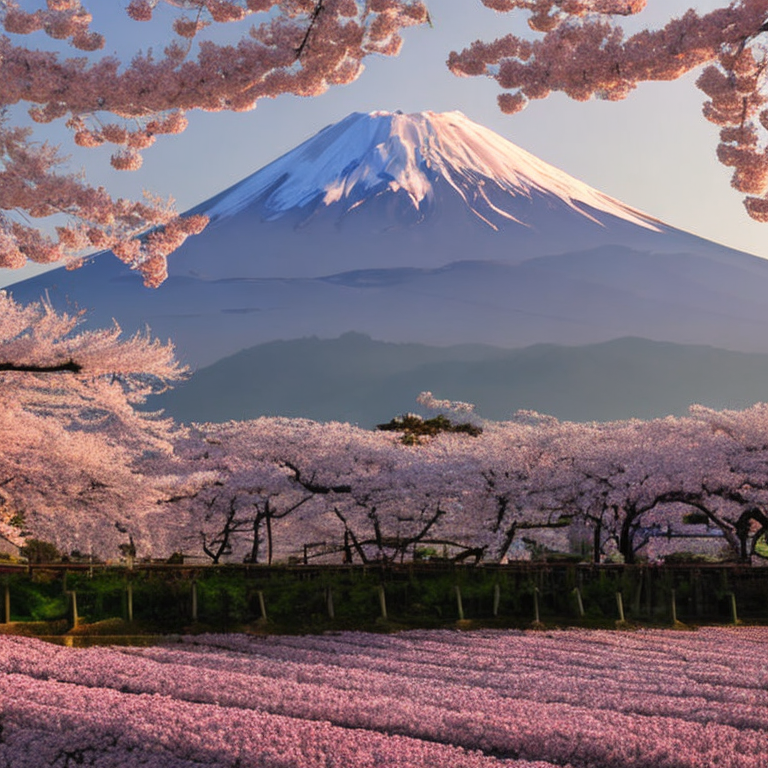

In [15]:
prompt = "a beautiful photograph of Mt. Fuji during cherry blossom"
image = pipe(prompt).images[0]
display(image)

# Run Stable Diffusion with TensorRT

### Initialize TensorRT txt2img pipeline

TensorRT pipeline initialization is similar to the native pipeline, with a single extra option to specify the path to a [python file containing the TensorRT implementation](https://github.com/huggingface/diffusers/blob/main/examples/community/stable_diffusion_tensorrt_txt2img.py) in diffusers.
`custom_pipeline="stable_diffusion_tensorrt_txt2img"`

In [16]:
pipe_trt = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    custom_pipeline="stable_diffusion_tensorrt_txt2img",
    revision='fp16',
    torch_dtype=torch.float16,
    scheduler=scheduler,
    image_height=512,
    image_width=512)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


### Specify cache folder name

The ONNX models and TensorRT engines generated during the first inference run will be cached in this folder to speed up subsequent runs.

In [17]:
pipe_trt.set_cached_folder("stabilityai/stable-diffusion-2-1", revision='fp16')

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### Build and load TensorRT engines

The overloaded `to()` method builds the TensorRT engines and loads them up for inference.

Note: ONNX export and TensorRT engine builds can take upto 20 minutes. Since the engines are cached, this latency is only observed on the first run below.

In [18]:
pipe_trt = pipe_trt.to("cuda")

Running inference on device: cuda:0
Building Engines...
Engine build can take a while to complete
Exporting model: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/clip.onnx
/usr/local/lib/python3.8/dist-packages/transformers/models/clip/modeling_clip.py:759: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask.fill_(torch.tensor(torch.finfo(dtype).min))
/usr/local/lib/python3.8/dist-packages/transformers/models/clip/modeling_clip.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the t

========== Diagnostic Run torch.onnx.export version 1.14.0a0+44dac51 ===========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[W] 'colored' module is not installed, will not use colors when logging. To enable colors, please install the 'colored' module: python3 -m pip install colored
[I] Folding Constants | Pass 1


2023-05-03 04:33:51.406400843 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/Unsqueeze
2023-05-03 04:33:51.406435531 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/Unsqueeze_3
2023-05-03 04:33:51.406444151 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/Unsqueeze_2


[I]     Total Nodes | Original:  2984, After Folding:  1952 |  1032 Nodes Folded
[I] Folding Constants | Pass 2


2023-05-03 04:33:52.696879372 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/encoder/layers.22/self_attn/Unsqueeze_12
2023-05-03 04:33:52.696910088 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/encoder/layers.22/self_attn/Unsqueeze_9
2023-05-03 04:33:52.696918469 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/encoder/layers.22/self_attn/Unsqueeze_17
2023-05-03 04:33:52.696926095 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/encoder/layers.22/self_attn/Unsqueeze_16
2023-05-03 04:33:52.696934158 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /text_model/encoder/layers.22/self_attn/Unsqueeze_14
2023-05-03 04:33:52.696942510 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /tex

[I]     Total Nodes | Original:  1952, After Folding:  1625 |   327 Nodes Folded
[I] Folding Constants | Pass 3
[I]     Total Nodes | Original:  1625, After Folding:  1625 |     0 Nodes Folded


Building Engines...
Engine build can take a while to complete
Exporting model: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/unet.onnx
/usr/local/lib/python3.8/dist-packages/diffusers/models/unet_2d_condition.py:650: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if any(s % default_overall_up_factor != 0 for s in sample.shape[-2:]):
/usr/local/lib/python3.8/dist-packages/diffusers/models/resnet.py:200: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert hidden_states.shape

========== Diagnostic Run torch.onnx.export version 1.14.0a0+44dac51 ===========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Generating optimizing model: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/unet.opt.onnx


[I] Folding Constants | Pass 1
[I]     Total Nodes | Original:  7757, After Folding:  5379 |  2378 Nodes Folded
[I] Folding Constants | Pass 2


2023-05-03 04:35:05.063804462 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /up_blocks.3/attentions.2/transformer_blocks.0/attn2/Unsqueeze_23
2023-05-03 04:35:05.063835442 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /up_blocks.3/attentions.2/transformer_blocks.0/attn1/Unsqueeze_23
2023-05-03 04:35:05.063851254 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /up_blocks.3/attentions.2/Unsqueeze_6
2023-05-03 04:35:05.063860151 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /up_blocks.3/attentions.2/Unsqueeze_2
2023-05-03 04:35:05.063874574 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /up_blocks.3/attentions.1/transformer_blocks.0/attn2/Unsqueeze_23
2023-05-03 04:35:05.063885250 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove

[I]     Total Nodes | Original:  5379, After Folding:  4208 |  1171 Nodes Folded
[I] Folding Constants | Pass 3
[I]     Total Nodes | Original:  4208, After Folding:  4208 |     0 Nodes Folded


Building Engines...
Engine build can take a while to complete
Exporting model: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/vae.onnx


========== Diagnostic Run torch.onnx.export version 1.14.0a0+44dac51 ===========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Generating optimizing model: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/vae.opt.onnx


[I] Folding Constants | Pass 1
[I]     Total Nodes | Original:   671, After Folding:   500 |   171 Nodes Folded
[I] Folding Constants | Pass 2


2023-05-03 04:35:36.443555280 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /decoder/mid_block/attentions.0/Unsqueeze_29
2023-05-03 04:35:36.443582656 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /decoder/mid_block/attentions.0/Unsqueeze_26
2023-05-03 04:35:36.443597966 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /decoder/mid_block/attentions.0/Unsqueeze_31
2023-05-03 04:35:36.443606789 [W:onnxruntime:, unsqueeze_elimination.cc:20 Apply] UnsqueezeElimination cannot remove node /decoder/mid_block/attentions.0/Unsqueeze_1


[I]     Total Nodes | Original:   500, After Folding:   471 |    29 Nodes Folded
[I] Folding Constants | Pass 3
[I]     Total Nodes | Original:   471, After Folding:   471 |     0 Nodes Folded


Building TensorRT engine for /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/clip.opt.onnx: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/clip.plan
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:604] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:81] The total number of bytes read was 681566094
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:604] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (o

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[I]     Configuring with profiles: [Profile().add('input_ids', min=(1, 77), opt=(1, 77), max=(4, 77))]
[I] Loading tactic timing cache from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/timing_cache
[W] Timing cache file /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/timing_cache not found, falling back to empty timing cache.
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 40535.88 MiB, TACTIC_DRAM: 40535.88 MiB]
    Tactic Sources         | []
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [DISABLE_EXTERNAL_TACTIC_S

Building TensorRT engine for /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/unet.opt.onnx: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/unet.plan
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:604] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:81] The total number of bytes read was 1733934759
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:604] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (

[W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[I]     Configuring with profiles: [Profile().add('sample', min=(2, 4, 96, 96), opt=(2, 4, 96, 96), max=(8, 4, 96, 96)).add('encoder_hidden_states', min=(2, 77, 1024), opt=(2, 77, 1024), max=(8, 77, 1024)).add('timestep', min=[1], opt=[1], max=[1])]
[I] Loading tactic timing cache from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/timing_cache
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 40535.88 MiB, TACTIC_DRAM: 40535.88 MiB]
    Tactic Sources         | []
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[W] - 272 weights are affected by this issue: Detected subnormal FP16 values.
[I] Finished engine building in 103

Building TensorRT engine for /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/onnx/vae.opt.onnx: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan


[I]     Configuring with profiles: [Profile().add('latent', min=(1, 4, 96, 96), opt=(1, 4, 96, 96), max=(4, 4, 96, 96))]
[I] Loading tactic timing cache from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/timing_cache
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 40535.88 MiB, TACTIC_DRAM: 40535.88 MiB]
    Tactic Sources         | []
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[W] - 4 weights are affected by this issue: Detected subnormal FP16 values.
[I] Finished engine building in 204.808 seconds
[I] Saving tactic timing cache to /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/timing_cache


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/clip.plan


[I] Saving engine to /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan
[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/clip.plan


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/unet.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/unet.plan


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan


In [19]:
pipe_trt = pipe_trt.to("cuda")

Running inference on device: cuda:0
Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/clip.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/clip.plan


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/unet.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/unet.plan


Loading TensorRT engine: /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan


[I] Loading bytes from /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/engine/vae.plan


/root/.cache/huggingface/modules/diffusers_modules/git/stable_diffusion_tensorrt_txt2img.py:907: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


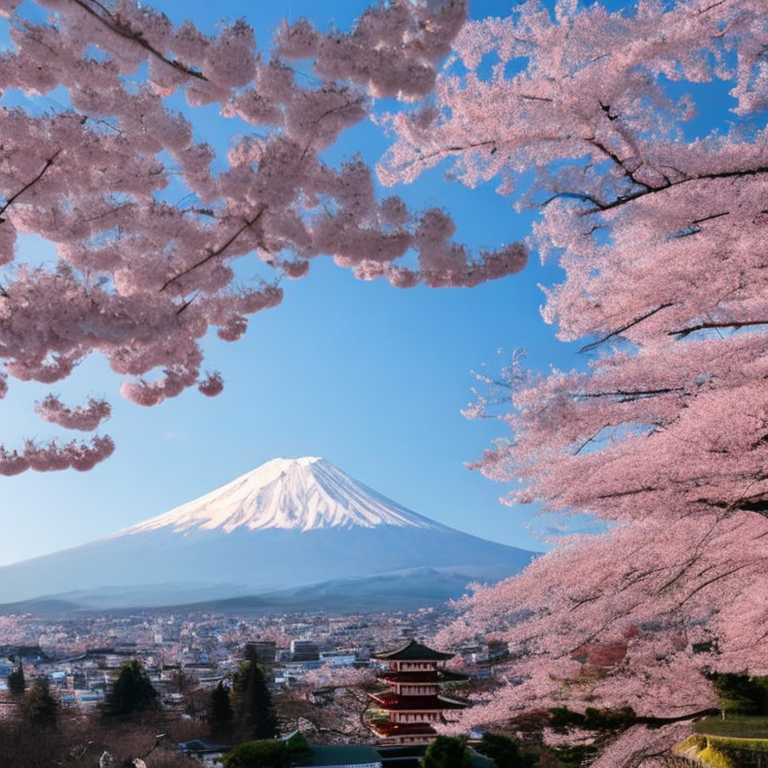

In [ ]:
prompt = "a beautiful photograph of Mt. Fuji during cherry blossom"

# warm up runs to stabilize performance benchmarking
num_warm_up_steps=5
for _ in range(num_warm_up_steps):
    _ = pipe_trt(prompt)

image = pipe_trt(prompt).images[0]
display(image)